In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from scipy.fftpack import ifft, fft, fftshift, fftfreq
from scipy.constants import pi, c

# Signal Model and Pulse Compression

## Signal Model

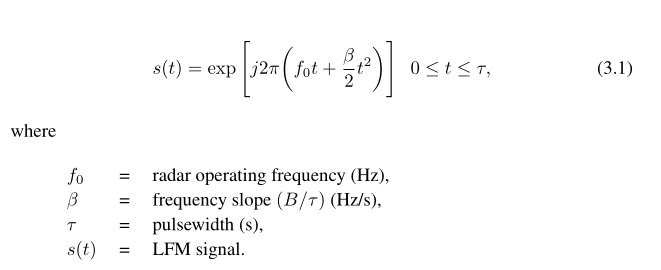
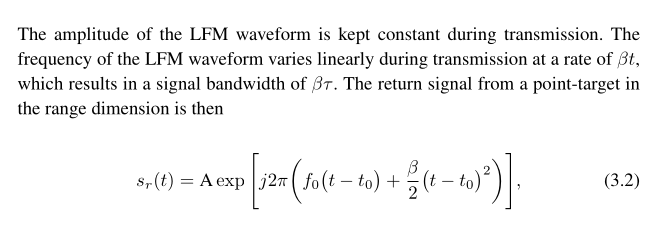

In [2]:
num_samples = 1024
t, dt = np.linspace(-1, 1, num_samples, retstep=True)
t0 = 0.2
bandwidth = 20
pulse_width = 2
chirp_rate = bandwidth / pulse_width
frequencies = fftshift(fftfreq(num_samples, dt))

st = np.exp(1j * chirp_rate * pi * t ** 2)
sr = np.exp(1j * chirp_rate * pi * (t - t0) ** 2)

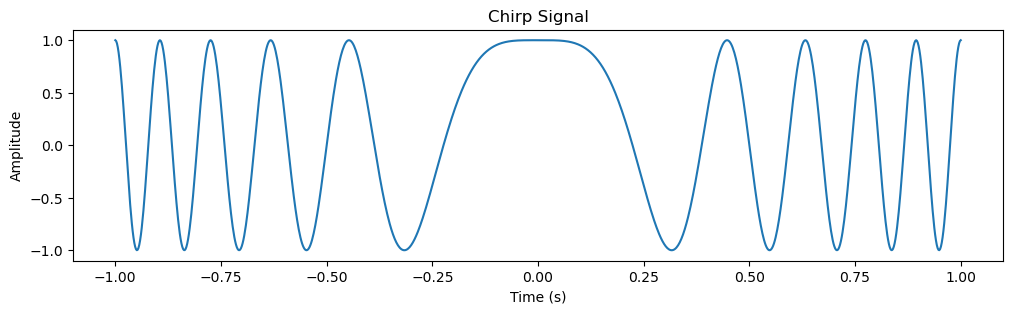

In [3]:
fig = plt.figure(1, figsize=(12, 3))
plt.plot(t, st.real)
plt.title('Chirp Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Pulse Compression Techniques

### Matched Filtering (AKA Correlation Processing)
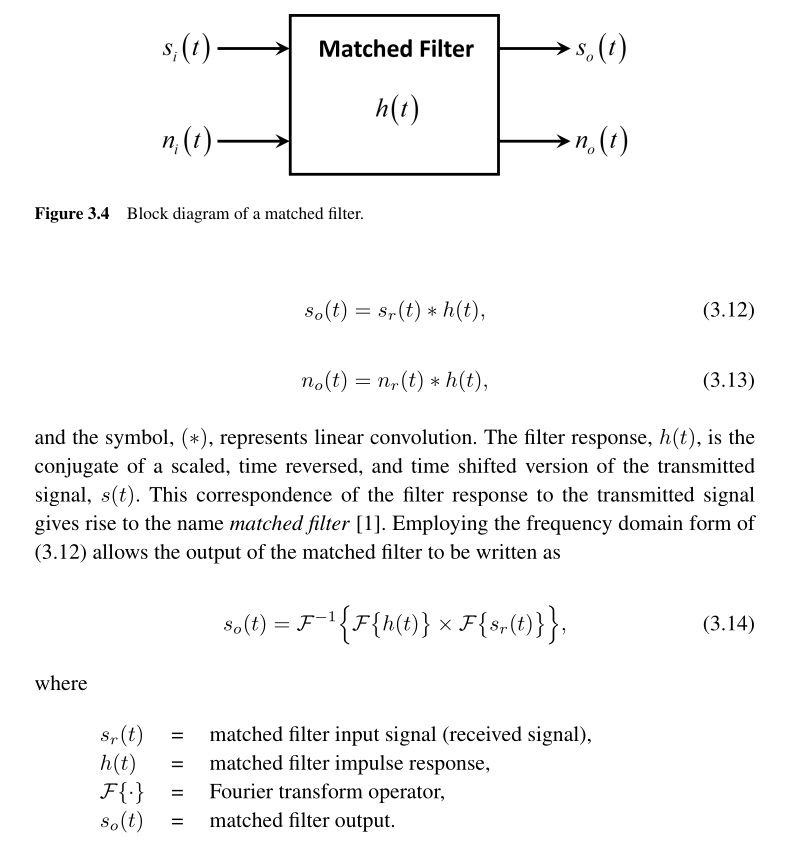

In [4]:
# Match Filter in Frequency Space
Hf = fft(np.conj(st))
# Recieved Signal in Frequency Space
Si = fft(sr)
# Convolution of Received Signal and Match Filter
so = fftshift(ifft(Si * Hf))
# Normalized Output
so_norm = np.abs(so) / np.max(np.abs(so))

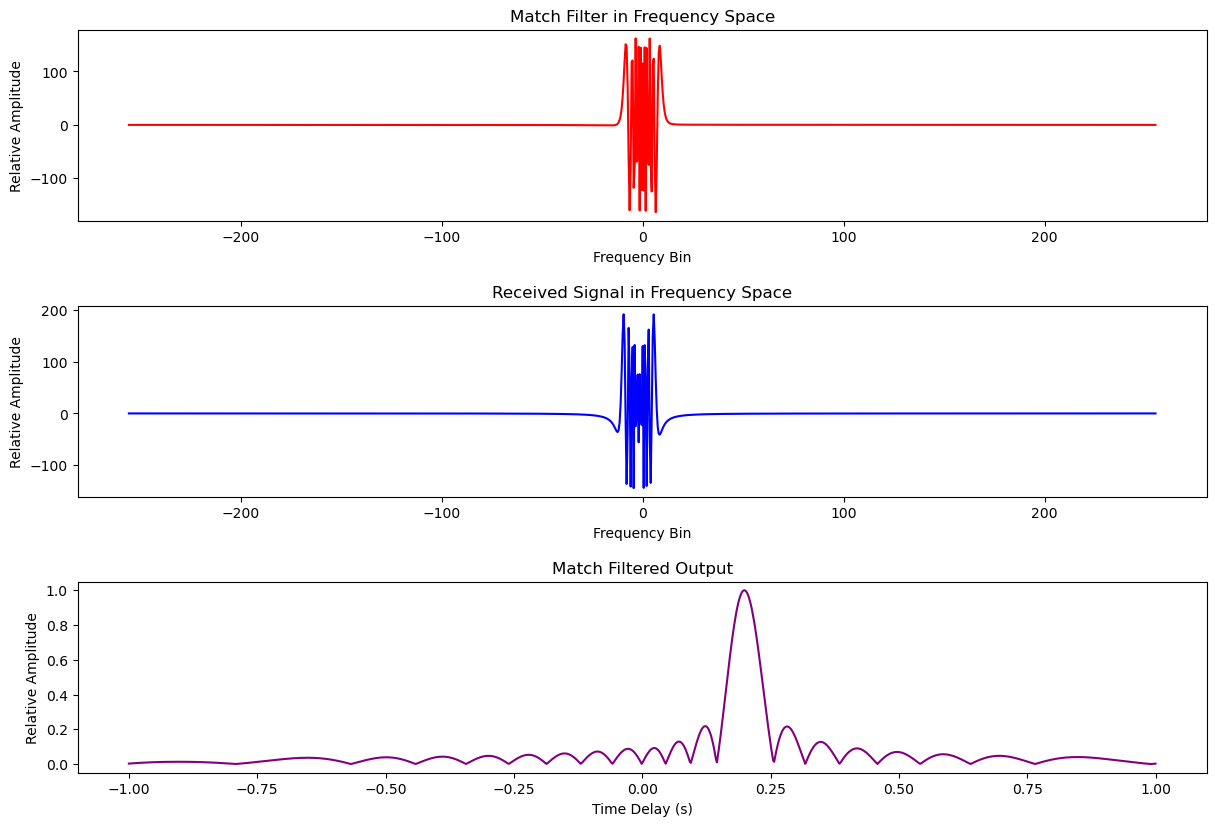

In [5]:
figure, axis = plt.subplots(3, 1, figsize=(12, 8))

figure.tight_layout(pad=1, h_pad=4, w_pad=4)

axis[0].plot(frequencies, fftshift(Hf.real), color='red')
axis[0].set_title('Match Filter in Frequency Space')
axis[0].set_xlabel('Frequency Bin')
axis[0].set_ylabel('Relative Amplitude')

axis[1].plot(frequencies, fftshift(Si.real), color='blue')
axis[1].set_title('Received Signal in Frequency Space')
axis[1].set_xlabel('Frequency Bin')
axis[1].set_ylabel('Relative Amplitude')


axis[2].plot(t, so_norm, color='purple')
axis[2].set_title('Match Filtered Output')
axis[2].set_xlabel('Time Delay (s)')
axis[2].set_ylabel('Relative Amplitude')

plt.show()

#### Notes:
Notice that the impulse occurs at $0.2$ seconds, which is our $t_0$. The first nulls are at $\frac{+}{-} \frac{1}{B}$, therefore targets will need to be seperated by at least $\frac{1}{B}$ seconds in time to be unambiguous. This leads to a range resolution of $\frac{c}{2B}$ meters given the round-trip delay time of $\frac{2R}{c}$.

### Stretch Processing
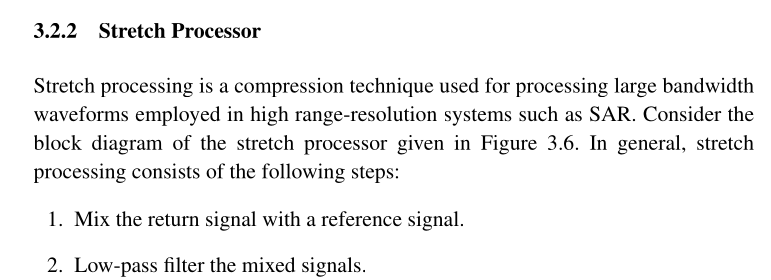
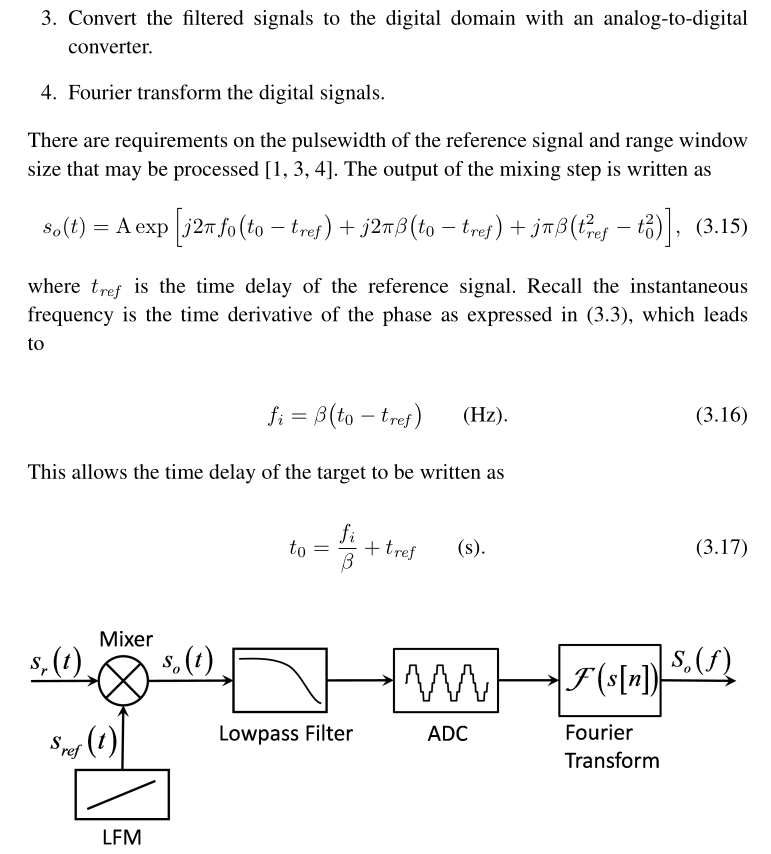
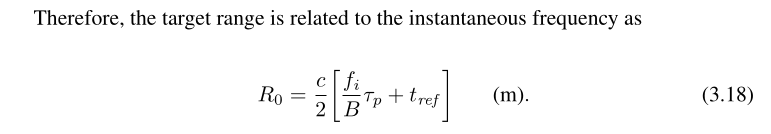

#### Results with Single Target

In [6]:
def stretch_processor(signal, pulsewidth, bandwidth, time_step):
    so_freq_space = fftshift(fft(so, 512))
    so_freq_space_norm = np.abs(so_freq_space)/np.max(np.abs(so_freq_space))
    frequencies = fftshift(fftfreq(512, time_step))
    range_window = 0.5 * frequencies * c * pulsewidth / bandwidth
    return so_freq_space_norm, range_window, frequencies

In [7]:
bandwidth = 50e6 # Hz
pulsewidth = 1e-3 # seconds
chirp_rate = bandwidth / pulsewidth # Hz/s
range_window_length = 50.0 # meters
num_samples = int(np.ceil(4 * bandwidth * range_window_length / c))

target_range = 15.0 # meters

t0 = 2.0 * target_range / c
t, dt = np.linspace(-0.5 * pulsewidth, 0.5 * pulsewidth, num_samples, retstep=True)

so = np.exp((1j * 2.0 * pi * chirp_rate * t * t0))

In [8]:
so_freq_space_norm, range_window, frequencies = stretch_processor(so, pulsewidth, bandwidth, dt)

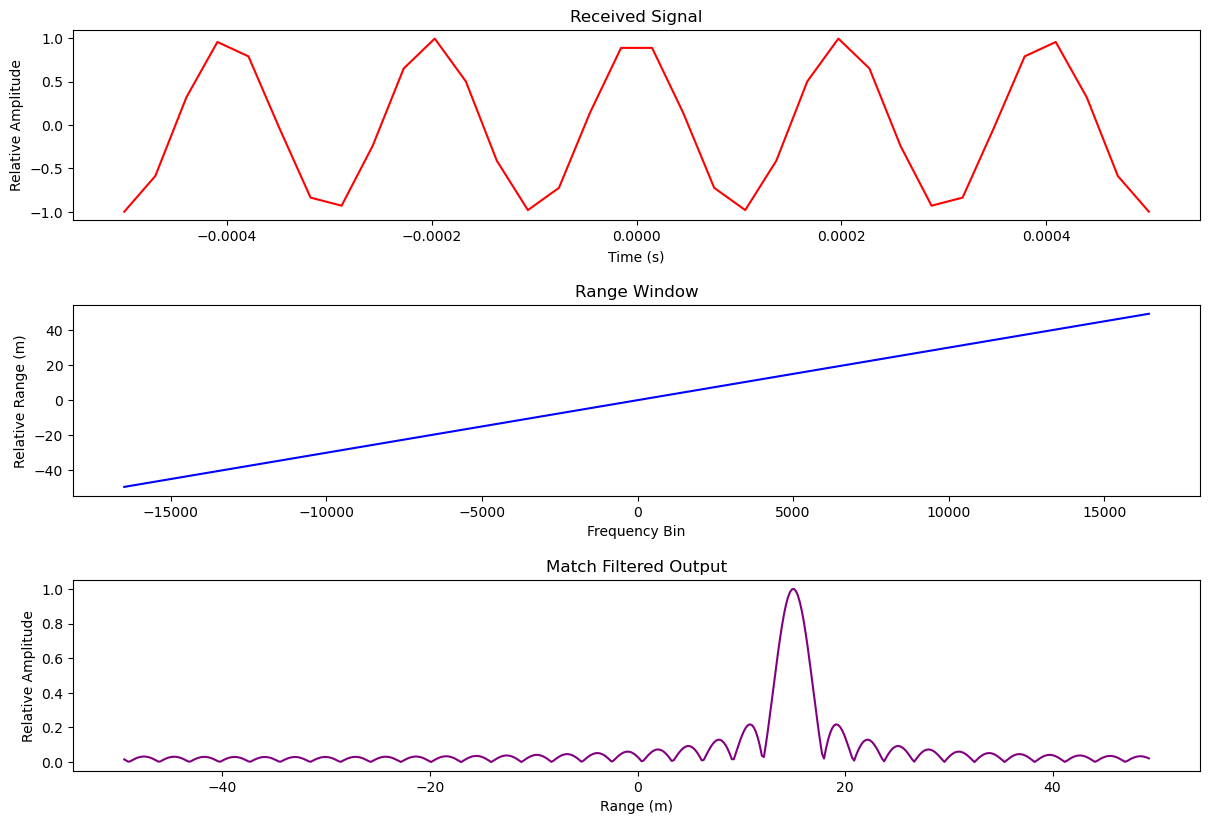

In [9]:
figure, axis = plt.subplots(3, 1, figsize=(12, 8))

figure.tight_layout(pad=1.08, h_pad=4, w_pad=None)

axis[0].plot(t, so.real, color='red')
axis[0].set_title('Received Signal')
axis[0].set_xlabel('Time (s)')
axis[0].set_ylabel('Relative Amplitude')

axis[1].plot(frequencies, range_window.real, color='blue')
axis[1].set_title('Range Window')
axis[1].set_xlabel('Frequency Bin')
axis[1].set_ylabel('Relative Range (m)')

axis[2].plot(range_window, so_freq_space_norm.real, color='purple')
axis[2].set_title('Match Filtered Output')
axis[2].set_xlabel('Range (m)')
axis[2].set_ylabel('Relative Amplitude')

plt.show()

In [10]:
estimated_target_range = range_window[np.argmax(np.abs(so_freq_space_norm))]

print(f"Estimated Target Range (m): {target_range}")

Estimated Target Range (m): 15.0


#### Results with Multiple Targets

In [11]:
target_ranges = np.asarray([5, 15, 40])

time_delays = 2.0 * target_ranges / c

t, dt = np.linspace(-0.5 * pulsewidth, 0.5 * pulsewidth, num_samples, retstep=True)

so = sum([np.exp(1j * 2.0 * pi * chirp_rate * t * time_delay) for time_delay in time_delays])

In [12]:
so_processed, range_window, frequencies = stretch_processor(so, pulsewidth, bandwidth, dt)

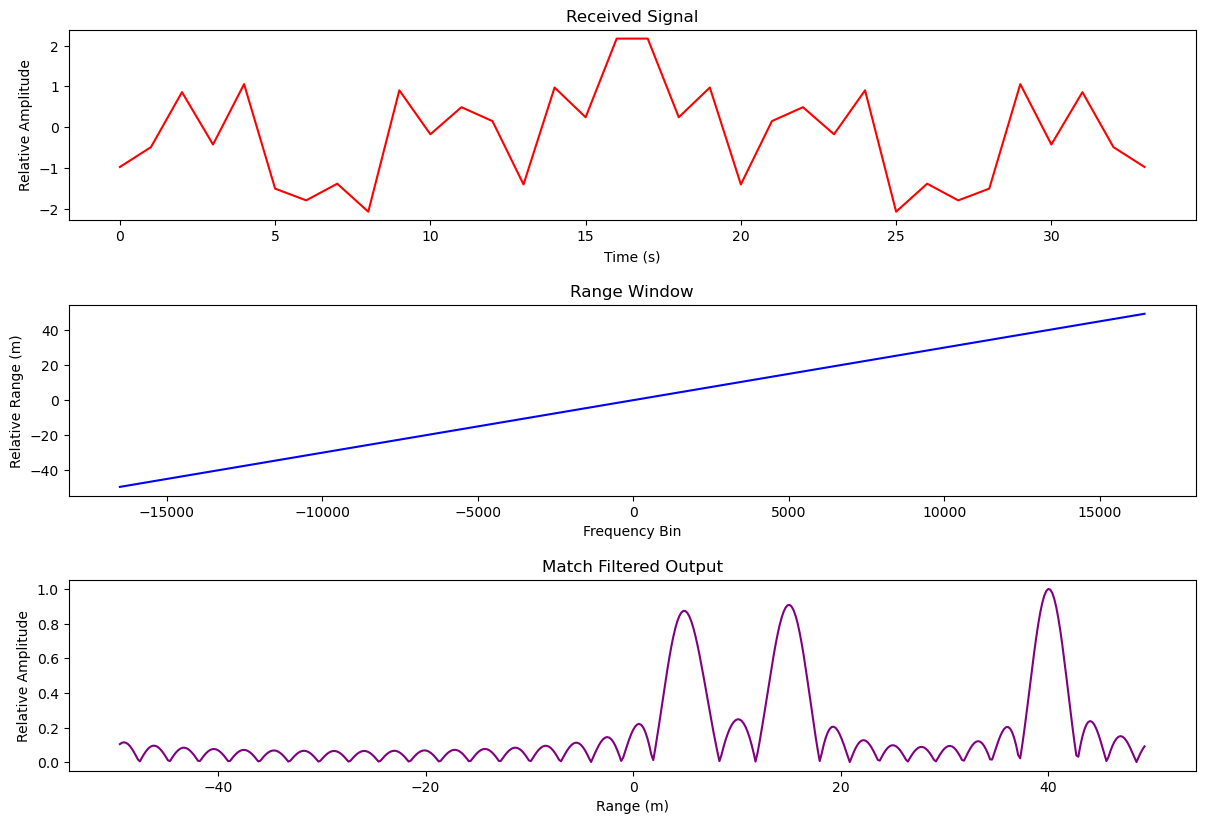

In [13]:
figure, axis = plt.subplots(3, 1, figsize=(12, 8))

figure.tight_layout(pad=1.08, h_pad=4, w_pad=None)

axis[0].plot(so.real, color='red')
axis[0].set_title('Received Signal')
axis[0].set_xlabel('Time (s)')
axis[0].set_ylabel('Relative Amplitude')

axis[1].plot(frequencies, range_window.real, color='blue')
axis[1].set_title('Range Window')
axis[1].set_xlabel('Frequency Bin')
axis[1].set_ylabel('Relative Range (m)')

axis[2].plot(range_window, so_processed.real, color='purple')
axis[2].set_title('Match Filtered Output')
axis[2].set_xlabel('Range (m)')
axis[2].set_ylabel('Relative Amplitude')

plt.show()

#### Simple Threshold Detection and Determining the Ranges of Multiple Targets

In [14]:
def detect_peaks(signal, threshold):
    width = signal.shape[0]
    peaks = []
    for i in range(0, width):
        if i < width - 1:
            is_above_threshold = so_processed[i] >= threshold
            is_peak_left = so_processed[i - 1] < so_processed[i]
            is_peak_right = so_processed[i + 1] < so_processed[i]
            if  is_above_threshold and is_peak_left and is_peak_right:
                peaks.append(i)
    return peaks

In [15]:
def get_estimated_ranges(peaks, range_window):
    estimated_ranges = [range_window[peak] for peak in peaks]
    return estimated_ranges

In [16]:
threshold = 0.8
peaks = detect_peaks(so_processed, threshold)
estimated_ranges = get_estimated_ranges(peaks, range_window)

In [17]:
print(f'Detected {len(peaks)} targets.')

for target_range, index in zip(estimated_ranges, range(0, len(estimated_ranges))):
    print(f'Estimated Range to Target {index}: {target_range:.5f}m')

Detected 3 targets.
Estimated Range to Target 0: 4.83064m
Estimated Range to Target 1: 15.07160m
Estimated Range to Target 2: 39.99770m


#### Notes:

The frequency resolution of the strech processor is $\frac{1}{\tau_p}$. In order to be unambiguous, two targets need to be seperated in range such that they are seperated by an amount greater than the frequency resolution, $f_{i, 2}-f_{i, 1} = \frac{B}{\tau_p}(t_2 - t_1) - \frac{B}{\tau_p}(t_2-t_1) >= \frac{1}{\tau_p}$; thus the time resolution is $\frac{1}{B}$. This leads us to determine that the range resolution is $\frac{2B}{c}$, which is the same as the match processor!

So why use one or the other?

The *match processor* only requires a received pulse and a replica of the transmitted pulse. This leads to a more simple implementation that requires less assumptions (such as the range window in strech processing). This simplicity has a cost: the FFTs go over all of the samples. This means that performace can be very bad with high-bandwidth chirps.

The *strech processor* requires you to limit the analysis to a limited window of range. The benefit of this is that the number of samples require for processing can be significantly lower, leading to much more efficient processing. With the default values above, there are only 33 time samples; in contrast, the match filter used 1024 time samples.